In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glove-word-embeddings/glove.csv
/kaggle/input/glove6b100dtxt/glove.6B.100d.txt


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
import string
import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
lemma = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
df_train.describe().T


,count,mean,std,min,25%,50%,75%,max
id,7613.0,5441.934848,3137.11609,1.0,2734.0,5408.0,8146.0,10873.0
target,7613.0,0.429660,0.49506,0.0,0.0,0.0,1.0,1.0


# Data cleaning and preprocessing


In [8]:
# Remove URL

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [9]:
# Remove Emoji

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002500-\U00002BEF"  
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [10]:
# Remove HTML

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

In [11]:
# Remove Punct

def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [12]:
# Remove Number

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'', text)

In [13]:
df_train['clean_text'] = df_train['text'].apply(lambda x: remove_url(x))
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: remove_emoji(x))
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: remove_html(x))
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: remove_punctuation(x))
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: remove_number(x))

# Tokenizing the cleaned texts

In [14]:
df_train['tokenized'] = df_train['clean_text'].apply(word_tokenize)
df_train.head()

,id,keyword,location,text,target,clean_text,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...,"[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala..."


In [15]:
#df_train['lower'] = df_train['clean_text'].apply(lambda x: [word.lower() for word in x])
#df_train['no_stopwords'] = df_train['lower'].apply(
#                            lambda x: [word for word in x if word not in set(nltk.corpus.stopwords.words('english'))])

In [16]:
#df_train['no_stopwords'] = [' '.join(map(str, l)) for l in df_train['no_stopwords']]
#df_train.head()

# Exploratory Data Analysis


In [17]:
#fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)

#sns.countplot(df_train['target'], ax=axes[0])
#axes[1].pie(df_train['target'].value_counts(),
#             labels=['Not Disaster', 'Disaster'],
#             autopct='%1.2f%%',
#             startangle=60)
           
#fig.suptitle('Distribution of the Tweets', fontsize=24)
#plt.show()

## Average number of words in a processed tweet


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'disaster tweets')

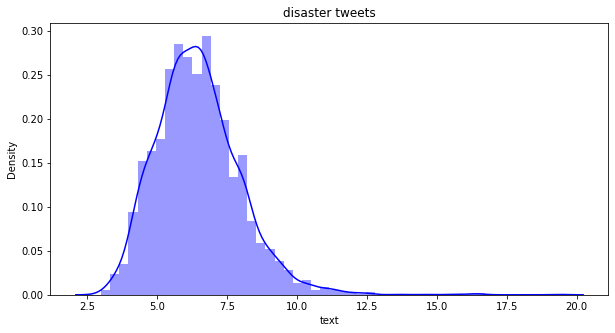

In [18]:
fig, ax1 = plt.subplots(figsize=(10,5))

word = df_train[df_train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('disaster tweets')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Non disaster tweets')

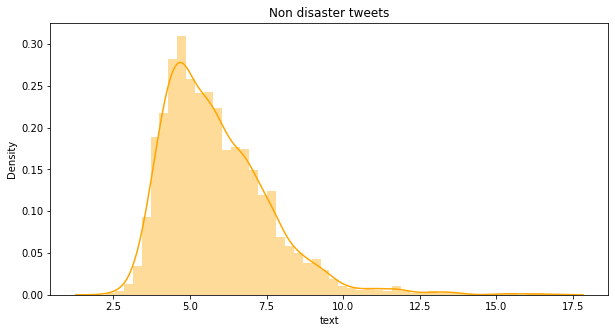

In [19]:
fig, ax2 = plt.subplots(figsize=(10,5))

word = df_train[df_train['target']==0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax2, color='orange')
ax2.set_title('Non disaster tweets')

# Load pretrained GloVe embedding
GloVe word embeddings are generated from a huge text corpus like Wikipedia and are able to find a meaningful vector representation for each word in the news data. This allows us to use Transfer learning and train further over our data. In this project I have used the 100-dimensional `max_sequence_length` data. When used with a BiLSTM, the results seem to be better than Bag-of-Words and Tf-Idf vectorization methods.

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [21]:
embedding_dim = 100
max_sequence_length = 100
max_nb_words = 64

In [22]:
embeddings_index = {}
f = open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt', encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [23]:
print('Indexing word vectors.')
print('Found %s word vectors.' % len(embeddings_index))
print('d_model: %s', embeddings_index['hi'].shape)

Indexing word vectors.
Found 400000 word vectors.
d_model: %s (100,)


In [24]:
from tqdm import tqdm
stop=set(stopwords.words('english'))

def create_corpus(train):
    data = []
    for tweet in tqdm(df_train['text']):
        words = [word.lower() for word in word_tokenize(tweet) 
                 if((word.isalpha()==1) & 
                    (word not in stop))]
        
        data.append(words)
    return data

In [25]:
data = create_corpus(df_train)

100%|██████████| 7613/7613 [00:02<00:00, 2956.44it/s]


In [26]:
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(data)
sequences = tokenizer_obj.texts_to_sequences(data)
word_index = tokenizer_obj.word_index

tweet_pad = pad_sequences(sequences, maxlen=max_sequence_length, truncating='post', padding='post')
word_index = tokenizer_obj.word_index

In [27]:
print('Found %s unique tokens.' % len(word_index))
print(tweet_pad.shape)
print(tweet_pad)

Found 15013 unique tokens.
(7613, 100)
[[ 594 4160  737 ...    0    0    0]
 [ 117    8  161 ...    0    0    0]
 [ 118 1574 1456 ...    0    0    0]
 ...
 [1444  290  504 ...    0    0    0]
 [  20 1004  256 ...    0    0    0]
 [   3  138   85 ...    0    0    0]]


In [28]:
num_words = len(word_index) + 1

# LSTM model

In [29]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization,SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [30]:
X = sequences
X = pad_sequences(X, maxlen=max_sequence_length)
print(X[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  594 4160  737  191   72 1455
 4161   30]


In [31]:
tokenizer_obj.sequences_to_texts([[594, 4160, 737, 191, 72, 1455, 4161, 30]])

['our deeds reason earthquake may allah forgive us']

In [32]:
y = df_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [33]:
embed_dim = embedding_dim
lstm_out = 64

## Hybrid model

In [34]:
def build_hybrid_model():
    model = Sequential()
    
    model.add(layers.InputLayer(input_shape=(max_sequence_length,), name="input"))
    model.add(layers.Embedding(input_dim=embedding_dim,
                               output_dim=150,
                               input_length=max_sequence_length))
    
    model.add(layers.Conv1D(filters=32, kernel_size=3, 
                            padding='same', 
                            activation='relu', 
                            kernel_regularizer=l2(0.01), 
                            bias_regularizer=l2(0.01)))
    
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.LSTM(64, recurrent_dropout=0.5, 
                          kernel_regularizer=l2(0.01), 
                          recurrent_regularizer=l2(0.01), 
                          bias_regularizer=l2(0.01)))
    
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=["accuracy"])
    return model

In [35]:
model = Sequential()

model.add(Embedding(num_words, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4)))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.003)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.hs', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])

print(model.summary())

2022-05-23 18:23:15.996638: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1501400   
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 32)           9632      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,560,825
Trainable params: 1,560,825
Non-trainable params: 0
______________________________________________

In [36]:
history = model.fit(X_train, y_train, epochs=10, callbacks=[es, mc], batch_size=32, validation_data=(X_test, y_test))

2022-05-23 18:23:16.944795: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
191/191 [==============================] - 75s 353ms/step - loss: 0.5269 - accuracy: 0.7337 - val_loss: 0.4372 - val_accuracy: 0.8076
Epoch 2/10
191/191 [==============================] - 69s 361ms/step - loss: 0.2796 - accuracy: 0.8915 - val_loss: 0.4972 - val_accuracy: 0.7892
Epoch 3/10
191/191 [==============================] - 67s 352ms/step - loss: 0.1423 - accuracy: 0.9479 - val_loss: 0.5939 - val_accuracy: 0.7715
Epoch 4/10
191/191 [==============================] - 68s 357ms/step - loss: 0.0830 - accuracy: 0.9690 - val_loss: 0.7943 - val_accuracy: 0.7649
Epoch 5/10
191/191 [==============================] - 68s 356ms/step - loss: 0.0520 - accuracy: 0.9757 - val_loss: 0.9112 - val_accuracy: 0.7623
Epoch 00005: early stopping


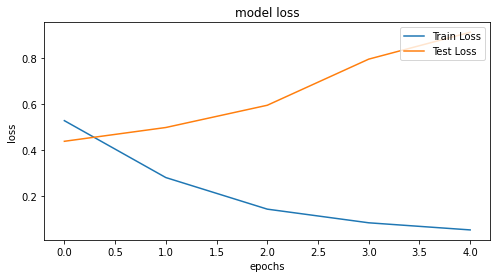

In [37]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [38]:
y_predict = model.predict(X_test).round()

In [39]:
y_predict

array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

# Evaluation

In [40]:
from sklearn import metrics

train_accuracy = round(metrics.accuracy_score(y_train, model.predict(X_train).round()) * 100)
train_accuracy

98

In [41]:
print('Accuracy : ', (metrics.accuracy_score(y_test, y_predict)))
print('Recall :', (metrics.recall_score(y_test, y_predict)))
print('Precision : ', (metrics.precision_score(y_test, y_predict)))

Accuracy :  0.7623112278397899
Recall : 0.7286585365853658
Precision :  0.7220543806646526


In [42]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       867
           1       0.72      0.73      0.73       656

    accuracy                           0.76      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.76      0.76      0.76      1523



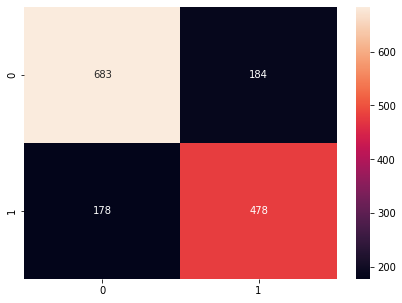

In [43]:
conm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(7, 5))
sns.heatmap(conm, annot=True, fmt='d')
plt.show()

# Test Set and get Submission

In [44]:
df_test['clean_text'] = df_test['text'].apply(lambda x: remove_url(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: remove_emoji(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: remove_html(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: remove_punctuation(x))

In [45]:
df_test['clean_text'].head()

0                   Just happened a terrible car crash
1    Heard about earthquake is different cities sta...
2    there is a forest fire at spot pond geese are ...
3                Apocalypse lighting Spokane wildfires
4        Typhoon Soudelor kills 28 in China and Taiwan
Name: clean_text, dtype: object

In [46]:
def create_corpus(test):
    data = []
    for tweet in tqdm(df_test['clean_text']):
        words = [word.lower() for word in word_tokenize(tweet) 
                 if((word.isalpha()==1) & 
                    (word not in stop))]
        
        data.append(words)
    return data

In [47]:
data_test = create_corpus(df_test)

100%|██████████| 3263/3263 [00:00<00:00, 4268.89it/s]


In [48]:
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(data_test)
sequences = tokenizer_obj.texts_to_sequences(data_test)
word_index = tokenizer_obj.word_index

tweet_pad = pad_sequences(sequences, maxlen=max_sequence_length,truncating='post', padding='post')
word_index = tokenizer_obj.word_index

In [49]:
print('Found %s unique tokens.' % len(word_index))
print(tweet_pad.shape)
print(tweet_pad)

Found 9735 unique tokens.
(3263, 100)
[[ 114  522  885 ...    0    0    0]
 [ 194  195 1751 ...    0    0    0]
 [  60    6  794 ...    0    0    0]
 ...
 [ 604  224  625 ...    0    0    0]
 [3443  591  378 ...    0    0    0]
 [3124 3131 1678 ...    0    0    0]]


In [50]:
num_words = len(word_index) + 1
print(num_words)

9736


In [51]:
X = sequences
X = pad_sequences(X, maxlen=max_sequence_length)
print(X[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0 114 522 885  69  36]


In [52]:
tokenizer_obj.sequences_to_texts([[114, 522, 885, 69, 36]])

['just happened terrible car crash']

In [53]:
model = Sequential()

model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4)))
model.add(Dense(1, activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.003)

In [54]:
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          973600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               49664     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,033,025
Trainable params: 1,033,025
Non-trainable params: 0
____________________________________________

In [55]:
from tensorflow import keras

callbacks_es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X,y, epochs = 10,validation_split = 0.2 ,callbacks=[callbacks_es], batch_size=32)

Epoch 1/10
82/82 [==============================] - 38s 368ms/step - loss: 0.6638 - accuracy: 0.6123 - val_loss: 0.6929 - val_accuracy: 0.5528
Epoch 2/10
82/82 [==============================] - 28s 348ms/step - loss: 0.4298 - accuracy: 0.8111 - val_loss: 0.7308 - val_accuracy: 0.5881
Epoch 3/10
82/82 [==============================] - 28s 347ms/step - loss: 0.2052 - accuracy: 0.9310 - val_loss: 1.0536 - val_accuracy: 0.5681
Epoch 4/10
82/82 [==============================] - 28s 347ms/step - loss: 0.1261 - accuracy: 0.9575 - val_loss: 1.0654 - val_accuracy: 0.5881


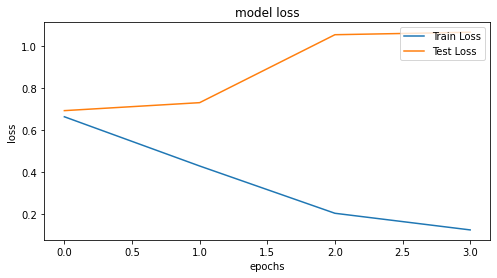

In [56]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [57]:
y_hat = model.predict(tweet_pad).round()
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = np.round(y_hat).astype('int')

In [58]:
submission.describe().style

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.611094
std,3146.427221,0.487577
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,1.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [59]:
submission.to_csv('submission.csv', index=False)